In [29]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import GWFish.modules as gwf_mods
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import os
import h5py
import pandas as pd
import pathlib
import numpy as np
import sys
sys.path.append('../')
import pylab as plt

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
param_file = os.path.join(base_dir, 
                          'SNR_output_files_XPHM',
                          'BBH',
                          'CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

## Choose 3 events with diverse SNRs

In [3]:
with h5py.File(param_file, 'r') as f:
    choice_events = {}
    cnt_low = 0
    cnt_med = 0
    cnt_high = 0
    snrs_netw = f['results']['SNR_network'][:]
    for i in range(len(f['results']['SNR_network'])):
        snr_netw = f['results']['SNR_network'][i]
        if snr_netw >= 12 and snr_netw < 13 and cnt_low == 0:
            choice_events['low_snr_event'] = {key:val[i] for key, val in f['results'].items()}
            cnt_low += 1
        elif snr_netw >= 50 and snr_netw < 51 and cnt_med == 0:
            choice_events['med_snr_event'] = {key:val[i] for key, val in f['results'].items()}
            cnt_med += 1
        elif snr_netw >= 500 and cnt_high == 0:
            choice_events['high_snr_event'] = {key:val[i] for key, val in f['results'].items()}
            cnt_high += 1

## FM analysis at original parameters

In [4]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}

In [5]:
def get_gwfish_input_data(inj_data):
    gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data[key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
    gwfish_input_data = pd.DataFrame(gwfish_input_data, index=[0])
    gwfish_input_data['mass_ratio'] = 1/inj_data['q']
    return gwfish_input_data

In [6]:
get_gwfish_input_data(choice_events['low_snr_event'])

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,90.211996,62025.534638,1.729578,2.41491,-0.159548,1.972306,1.893081e+09,0.465746,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359,143.031817,76.53566,0.535095


In [7]:
detectors = ['CE1', 'CE2', 'ET']
results = {'detected_idxs':{}, 
           'netw_snrs':{}, 
           'errors':{},
           'sky_locs':{}}
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 5.), config=pathlib.Path('detectors.yaml'))
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    results['detected_idxs'][event_type], results['netw_snrs'][event_type], results['errors'][event_type], results['sky_locs'][event_type] = compute_network_errors(
        network=network, 
        parameter_values=get_gwfish_input_data(choice_events[event_type]),
        fisher_parameters=fisher_params, 
        f_ref=5, 
        waveform_model='IMRPhenomXPHM',
        save_matrices=True,
        save_matrices_path=pathlib.Path('./temp_matrices/'),
        matrix_naming_postfix=event_type)
    results['errors'][event_type] = pd.DataFrame(results['errors'][event_type], columns=fisher_params)

100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


In [8]:
results['cov'] = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    matrix_file_names = event_type
    results['cov'][event_type] = np.load(os.path.join('./temp_matrices/', f'inv_fisher_matrices_{matrix_file_names}.npy'))[0]

## Convert cov to logDL and logMc

In [9]:
from utils import transform_cov_DL_Mc_to_logDL_logMc
DL_idx = fisher_params.index('luminosity_distance')
Mc_idx = fisher_params.index('chirp_mass')
results['new_cov'] = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    new_cov = transform_cov_DL_Mc_to_logDL_logMc(results['cov'][event_type],
                                                 choice_events[event_type]['distance'], DL_idx, 
                                                 choice_events[event_type]['mchirp'], Mc_idx)
    results['new_cov'][event_type] = new_cov

In [10]:
results['errors']['high_snr_event']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.000368,0.010584,8.721666,0.008994,7.059332,0.000017,0.000766,0.001587,3.529679


In [11]:
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    results['errors'][event_type]['log_luminosity_distance'] = results['errors'][event_type]['luminosity_distance']/choice_events[event_type]['distance']

### Check that the coversion was fine

In [12]:
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    print(np.sqrt(results['new_cov'][event_type][DL_idx, DL_idx])/results['errors'][event_type]['log_luminosity_distance'][0])

1.0
1.0
0.9999999999999999


## Create posterior samples

In [13]:
new_deriv_variables_in_order = []
for var in fisher_params:
    if var == 'luminosity_distance' or var == 'chirp_mass':
        new_deriv_variables_in_order.append(f'log_{var}')
    else:
        new_deriv_variables_in_order.append(var)

In [14]:
inj_params = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    inj_params[event_type] = {}
    for param in new_deriv_variables_in_order:
        if param == 'log_luminosity_distance':
            inj_params[event_type][param] = np.log(choice_events[event_type]['distance'])
        elif param == 'log_chirp_mass':
            inj_params[event_type][param] = np.log(choice_events[event_type]['mchirp'])
        else:
            inj_params[event_type][param] = get_gwfish_input_data(choice_events[event_type])[param][0]

In [15]:
param_bounds = {
    'chirp_mass':[1, np.inf],
    'log_chirp_mass':[0, np.inf],
    'mass_ratio':[1/20, 1],
    'luminosity_distance':[1, np.inf],
    'log_luminosity_distance':[0, np.inf],
    'theta_jn':[0, np.pi],
    'geocent_time':[-np.inf, np.inf],
    'ra':[0, 2*np.pi],
    'dec':[-np.pi/2, np.pi/2],
    'psi':[0, 2*np.pi],
    'phase':[0, 2*np.pi]
}

In [16]:
from tqdm import tqdm
import logging
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist
# Silence bilby warnings (set bilby logger to ERROR)
logging.getLogger('bilby').setLevel(logging.ERROR)
logging.getLogger('bilby.core').setLevel(logging.ERROR)

n_samples = 10000
posterior_samples = {}

for event_type in tqdm(['low_snr_event', 'med_snr_event', 'high_snr_event']):
    mu = [inj_params[event_type][param] for param in new_deriv_variables_in_order]
    cov = results['new_cov'][event_type]  # the covariance matrix
    mvg = MultivariateGaussianDist(new_deriv_variables_in_order, mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in new_deriv_variables_in_order])
    posterior_dists_i = dict()
    posterior_samples_i = {}
    for param in new_deriv_variables_in_order:
        posterior_dists_i[param] = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_dists_i[param].sample(n_samples)
    posterior_samples[event_type] = posterior_samples_i

100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


In [17]:
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    posterior_samples[event_type]['luminosity_distance'] = np.exp(posterior_samples[event_type]['log_luminosity_distance'])
    posterior_samples[event_type]['chirp_mass'] = np.exp(posterior_samples[event_type]['log_chirp_mass'])

## Calculate SNRs for the posterior samples

In [18]:
spin_keys = ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    for key in spin_keys:
        posterior_samples[event_type][key] = np.full(n_samples, get_gwfish_input_data(choice_events[event_type])[key][0])

In [19]:
gwfish_input_data_for_snr = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    gwfish_input_data_for_snr[event_type] = {key:val for key, val in posterior_samples[event_type].items() if 'log' not in key}
    gwfish_input_data_for_snr[event_type] = pd.DataFrame(gwfish_input_data_for_snr[event_type])

In [20]:
gwfish_input_data_for_snr['low_snr_event']

,mass_ratio,theta_jn,phase,geocent_time,ra,dec,psi,luminosity_distance,chirp_mass,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl
0,0.581587,1.721294,0.403276,1.893081e+09,2.392371,-0.139364,1.925432,58353.334312,90.208033,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
1,0.525749,1.653394,0.565687,1.893081e+09,2.406228,0.219212,2.000209,54510.747309,90.222933,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
2,0.559613,1.684856,0.686287,1.893081e+09,2.407547,-0.149919,1.997366,62371.211687,90.201701,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
3,0.529669,1.748091,0.226139,1.893081e+09,2.399763,-0.357412,1.991824,72294.590477,90.213013,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
4,0.523063,1.673148,0.320517,1.893081e+09,2.402763,-0.074544,1.910755,55160.192450,90.229813,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.549804,1.697001,0.629602,1.893081e+09,2.336104,-0.202739,2.016397,61814.674597,90.207290,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
9996,0.522837,1.682772,0.808281,1.893081e+09,2.402727,-0.354961,2.054055,88332.450842,90.208280,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
9997,0.526121,1.688503,0.525200,1.893081e+09,2.390040,-0.290507,1.976441,64855.856291,90.216577,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359
9998,0.519107,1.715817,0.394667,1.893081e+09,2.392720,-0.347766,2.036908,71482.964771,90.209482,0.159255,0.638618,0.651724,2.316439,2.994958,2.67359


In [21]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'cov', 'new_cov'])

In [22]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm
import GWFish.modules as gwf_mods

def compute_single_snr(row, network, f_ref):
    """Wrapper function needed for joblib."""
    return gwf_mods.utilities.get_snr(row, network, 'IMRPhenomXPHM', f_ref=f_ref)

results['new_snrs'] = {}

for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:

    input_data = gwfish_input_data_for_snr[event_type]
    f_ref = choice_events[event_type]['f_ref']

    # Parallel compute SNR row by row
    snr_list = Parallel(n_jobs=8, backend="loky")(
        delayed(compute_single_snr)(input_data[i:i+1], network, f_ref)
        for i in tqdm(range(len(input_data)))
    )

    # Combine
    results['new_snrs'][event_type] = pd.concat(snr_list, ignore_index=True)

  0%|          | 10/10000 [00:00<01:42, 97.09it/s]

100%|██████████| 10000/10000 [02:34<00:00, 64.54it/s]


In [23]:
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    results['new_snrs'][event_type].rename(columns={'CE1':'SNR_C1', 'CE2':'SNR_CE20', 'ET':'SNR_ET'}, inplace=True)
    results['new_snrs'][event_type].rename(columns={'network':'SNR_network'}, inplace=True)

## Get SNR from $\chi^2$ distribution

In [24]:
choice_events['low_snr_event'].keys()

dict_keys(['PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3', 'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time'])

In [25]:
from scipy.stats import ncx2
snr_from_chisq2 = {}
pycbc_dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    netw_mf_snr_sq = np.zeros(n_samples)
    for det in pycbc_dets:
        mf_snr_sq = ncx2.rvs(2, choice_events[event_type][f'SNR_{det}']**2, size=n_samples)
        netw_mf_snr_sq += mf_snr_sq
    snr_from_chisq2[event_type] = np.sqrt(netw_mf_snr_sq)

In [26]:
snr_from_chisq6 = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    snr_from_chisq6[event_type] = np.sqrt(ncx2.rvs(6, choice_events[event_type]['SNR_network']**2, size=n_samples))

## Get SNR from Gaussian distribution on individual dets

In [27]:
snr_from_gaussian_det = {}
pycbc_dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    netw_mf_snr_sq = np.zeros(n_samples)
    for det in pycbc_dets:
        mf_snr_sq = (np.random.normal(choice_events[event_type][f'SNR_{det}'], 1, size=n_samples))**2
        netw_mf_snr_sq += mf_snr_sq
    snr_from_gaussian_det[event_type] = np.sqrt(netw_mf_snr_sq)

## Get SNR from Gaussian distribution on netw

In [28]:
snr_from_gaussian_netw = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    snr_from_gaussian_netw[event_type] = np.random.normal(choice_events[event_type][f'SNR_network'], 1, size=n_samples)

#### Gaussian comparison plots

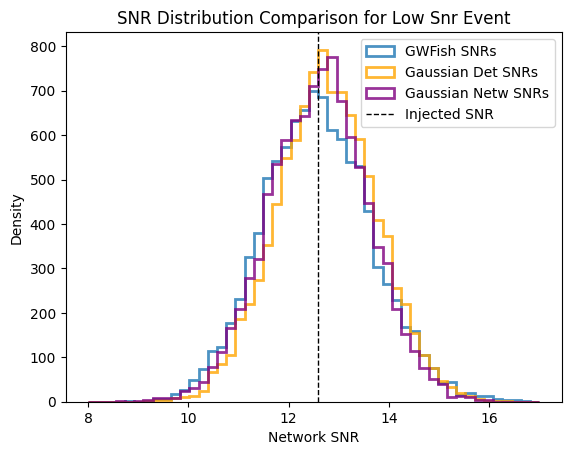

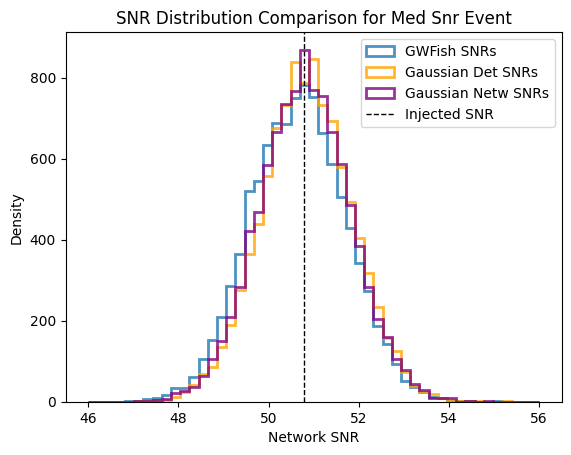

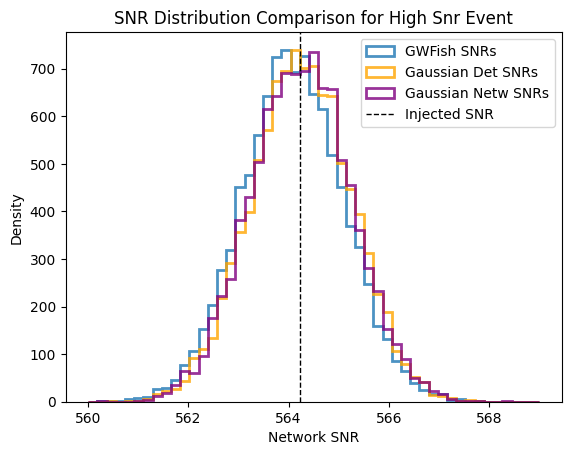

In [44]:
for event_type, bin_range in zip(['low_snr_event', 'med_snr_event', 'high_snr_event'], [(8, 17), (46, 56), (560, 569)]):
    bins = np.linspace(bin_range[0], bin_range[1], 50)
    plt.hist(results['new_snrs'][event_type]['SNR_network'], bins=bins, alpha=0.8, label='GWFish SNRs', histtype='step', lw=2)
    plt.hist(snr_from_gaussian_det[event_type], bins=bins, alpha=0.8, label='Gaussian Det SNRs', color='orange', histtype='step', lw=2)
    plt.hist(snr_from_gaussian_netw[event_type], bins=bins, alpha=0.8, label='Gaussian Netw SNRs', color='purple', histtype='step', lw=2)
    plt.axvline(choice_events[event_type]['SNR_network'], color='black', linestyle='dashed', linewidth=1, label='Injected SNR')
    plt.title(f'SNR Distribution Comparison for {event_type.replace("_", " ").title()}')
    plt.xlabel('Network SNR')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Comparison plots

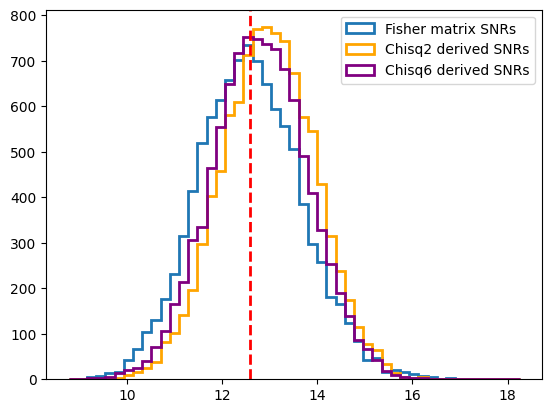

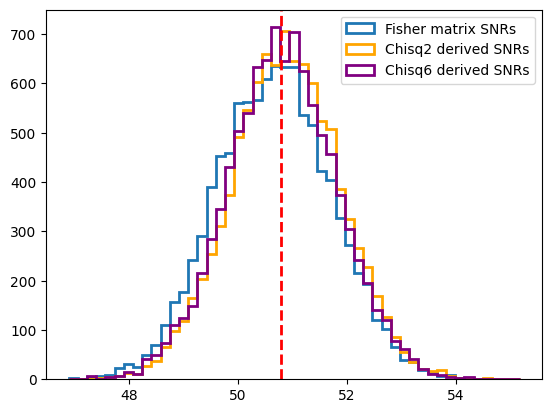

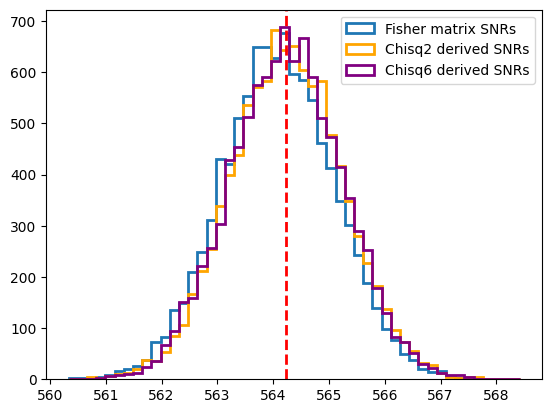

In [41]:
import pylab as plt
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    plt.figure()
    bins = np.linspace(np.min([results['new_snrs'][event_type]['SNR_network'].min(), snr_from_chisq2[event_type].min()]), 
                       np.max([results['new_snrs'][event_type]['SNR_network'].max(), snr_from_chisq2[event_type].max()]), 50)
    plt.hist(results['new_snrs'][event_type]['SNR_network'], bins=bins, histtype='step', label='Fisher matrix SNRs', lw=2)
    plt.hist(snr_from_chisq2[event_type], bins=bins, histtype='step', label='Chisq2 derived SNRs', color='orange', lw=2)
    plt.hist(snr_from_chisq6[event_type], bins=bins, histtype='step', label='Chisq6 derived SNRs', color='purple', lw=2)
    plt.axvline(choice_events[event_type]['SNR_network'], color='r', linestyle='dashed', linewidth=2)
    plt.legend()

In [31]:
snr_from_gaussian = {}
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    snr_from_gaussian[event_type] = np.random.normal(loc=choice_events[event_type]['SNR_network'], 
                                                             scale=1, size=n_samples)

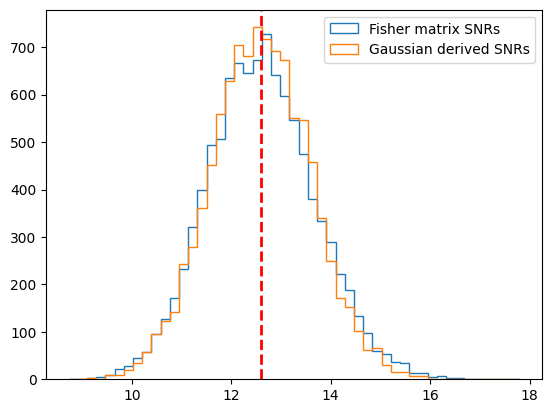

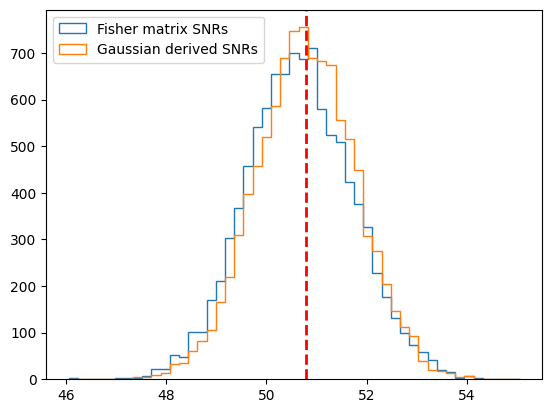

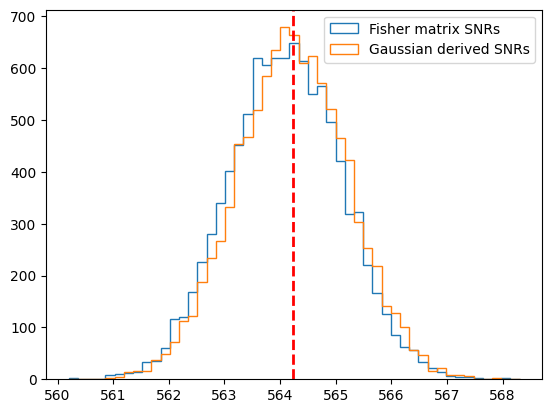

In [32]:
import pylab as plt
for event_type in ['low_snr_event', 'med_snr_event', 'high_snr_event']:
    plt.figure()
    bins = np.linspace(np.min([results['new_snrs'][event_type]['SNR_network'].min(), snr_from_chisq2[event_type].min()]), 
                       np.max([results['new_snrs'][event_type]['SNR_network'].max(), snr_from_chisq2[event_type].max()]), 50)
    plt.hist(results['new_snrs'][event_type]['SNR_network'], bins=bins, histtype='step', label='Fisher matrix SNRs')
    #plt.hist(snr_from_chisq2[event_type], bins=bins, histtype='step', label='Chisq2 derived SNRs')
    #plt.hist(snr_from_chisq6[event_type], bins=bins, histtype='step', label='Chisq6 derived SNRs')
    plt.hist(snr_from_gaussian[event_type], bins=bins, histtype='step', label='Gaussian derived SNRs')
    plt.axvline(choice_events[event_type]['SNR_network'], color='r', linestyle='dashed', linewidth=2)
    plt.legend()